In [3]:
# importy

# try:
#     import numpy as np # dá se naimportovat i cupy pro nvidia GPU
# except:
import cv2
import numpy as np
import numpy
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

In [4]:
# příprava

# najde všechny soubory v IN složce, aby se mohl loopnout
inputs_jpg = os.listdir("in/")
inputs = []

# vynechám ty s X
for a in inputs_jpg:
    if a[0] == "X":
        continue
    l = len(a)
    # odstraním .jpg
    short = a[:l - 4]
    inputs.append(short)

# předpřipravím si loop
for actual_img in inputs:
    break

actual_img = "2022_02_23_12_57_17"
save_debug = False

In [5]:
# loadnu originální obrázek + zamaluju ligi

# 1. načte BW obrázek
orig_bw = cv2.imread("in/{}.jpg".format(actual_img), 0) # 0 protože chci černobílý obrázek (pro krok úprava)

# zamalování loga UP
orig_bw = cv2.rectangle(orig_bw, (10000, 1211), (11800, 2100), (0), -1)
orig_bw = cv2.rectangle(orig_bw, (0, 1100), (1200, 2800), (0), -1)

# save
if save_debug:
    cv2.imwrite("debug/1.BW/{}.png".format(actual_img), orig_bw)

In [6]:
# crop

# ZLEVA A ZPRAVA 
# sečtu sloupce zvrchu dolů pro hledání ořezu zleva a zprava
suma_sloupec = np.array([])

for sloupec in range(len(orig_bw[0])):
    suma_sloupec = np.append(suma_sloupec, np.sum(orig_bw[:, sloupec]))

# hledám crop zleva a zprava
med = np.median(suma_sloupec) # vytvořím proměnnou s mediánem všech sloupců
med *= 1.25 # mírně posunu nahoru
medlist = np.where(suma_sloupec < med)[0] # 1D list s číslem sloupců, co jsou pod "med" číslem
ln = len(suma_sloupec) # získám šířku obrázku, IDK
lnn = ln // 2

h, w = orig_bw.shape[:2]

# vezmu první a poslední hodnotu v medlistu 
clft = medlist[0]
crgh = medlist[-1]

# pro pravý okraj speciálně dělám "pokročilejší" crop
# jinými slovy, najdu místo, kde je pár dalších směrem k centru pod mediánem
for x in range(0, w, 10):
    tmp = numpy.array([])
    for y in range(w//20):
        if suma_sloupec[-y - x] <= med:
            tmp = numpy.append(tmp, y)
    if len(tmp) > w // 20 // 1.5:
        crgh = w - x
        break
        



# ZVRCHU A ZESPODU #
# hledám crop zvrchu a zespodu
suma_radek = np.array([])

# sčítám řádky
for radek in range(len(orig_bw)):
    suma_radek = np.append(suma_radek, np.sum(orig_bw[radek]))

# hledám crop zvrchu a zespodu
med = np.median(suma_radek) # proměnná s mediánem ze všech řádků
med *= 1.25 # mírně posunu nahoru
medlist = np.where(suma_radek < med)[0]# 1D list s číslem sloupců, co jsou pod "med" číslem

# beru první a poslední hodnotu v medlist (list s indexy)
ctop = medlist[0]
cbot = medlist[-1]

# cropne obrázky podle předchozích kroků
margin = 0
crp = orig_bw[int(ctop+margin) : int(cbot-margin), int(clft+margin) : int(crgh-margin)]

# save
if save_debug:
    cv2.imwrite("debug/2.cropped/{}.png".format(actual_img), crp)

In [61]:
# OTSU

# celkový nápad je, že vezmu 4 čtverce (mírně nahoře, mírně dolů, mírně doleva, mírně doprava od zhruba začátku kořenu) a u každého 4 velikosti (200x200, 400x400, 800x800, 1600x1600)

# definuji funkci, která vezme obrázek a vrátí najitý threshold
def find_otsu(img):
    threshold, _ = cv2.threshold(img, 255, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)   
    return threshold
# malá funukce na otestování, jestli čtverec nezasahuje mimo obrázek, popř korekce
def check_otsu_crop(value, thresh):
    if thresh != 0:
        if value >= thresh:
            value = thresh
        return value
    elif thresh == 0:
        if value <= thresh:
            value = thresh
        return value

    else:
        print("you fucked up")
# hlavní část loopu, která se mnohokrát opakovala, tak proto je ve funkci
def najdi_otsu_thresh_ctverce(x, y, strana):
    # x a y beru jako zlomky
    x = int(w * x)
    y = int(h * y)

    # hodnoty pro crop
    hst = (y - strana) # hst je pro height start
    hen = (y + strana) # hen je pro height end
    wst = (x - strana) # wst je pro width start
    wen = (x + strana) # wen je pro width end

    # checku jestli nejdu ven z obrázku
    hst = check_otsu_crop(hst, 0)
    hen = check_otsu_crop(hen, h)
    wst = check_otsu_crop(wst, 0)
    wen = check_otsu_crop(wen, w)
    # print(hst, hen, wst, wen)
     
    otsu_crp = crp[hst : hen, wst : wen]
    # plt.imshow(otsu_crp)
    return find_otsu(otsu_crp)

h, w = crp.shape[:2]
otsus = []

pocet_x = 10
pocet_y = 10
pocet_stran = 10
maxim_hrana_strany = 5000

for x in range(pocet_x + 1):
    x += 1
    x /= pocet_x
    x *= w
    for y in range(pocet_y + 1):
        y += 1
        y /= pocet_y
        y *= h
        for z in range(pocet_stran):
            z += 1
            z *= int(maxim_hrana_strany/pocet_stran)
            # print(x, y ,z)
            # otsus.append(najdi_otsu_thresh_ctverce(x, y, z))
            print(najdi_otsu_thresh_ctverce(x, y, z))

# otsus je pole najitých hodnot otsuem

# APLIKACE THRESHOLDU
print(otsus)    
otsus = np.array(otsus)
maxi = otsus.max()
_, th_otsu = cv2.threshold(crp, maxi, 255, cv2.THRESH_BINARY)

th_otsu = np.uint8(th_otsu)
# maxi

# save
if True:
    cv2.imwrite("debug/3.Otsu/{}.png".format(actual_img), th_otsu)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


ValueError: zero-size array to reduction operation maximum which has no identity

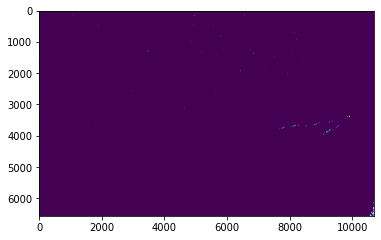

In [32]:
plt.imshow(th_otsu)